In [60]:
using NPZ
using Interpolations
using Cubature
using PyCall
using LinearAlgebra
using BenchmarkTools
# mpb = pyimport("meep.mpb")
# mp = pyimport("meep")
# @pyimport matplotlib.animation as anim
using PyPlot
# using Plots
# pyplot()
include("xray_3dphc.jl")

read_phc_data (generic function with 1 method)

In [2]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 10;
rcParams["font.sans-serif"] = "Arial";
rcParams["axes.labelsize"] = 12;
rcParams["xtick.labelsize"] = 12;
rcParams["ytick.labelsize"] = 12;
rcParams["legend.fontsize"] = 12;
rcParams["text.usetex"] = "False";
rcParams["svg.fonttype"] = "none";
rcParams["contour.negative_linestyle"] = "solid";
rcParams["contour.linewidth"] = 0.75;
rcParams["pcolor.shading"] = "auto";
rcParams["lines.linewidth"] = 0.75;
# rc("font", family="sans-serif")
# rc("font", size=12.0)
# rc("svg", fonttype="none")

In [3]:
cartesian_to_BCC_recip = 1/2 * [1 1 -1; -1 1 1; 1 -1 1]
BCC_to_cartesian_recip = [1 0 1; 1 1 0; 0 1 1]
BCC_recip_basis = [[1 1 0], [0 1 1], [1 0 1]]
BCC_basis = [[1/2 1/2 -1/2], [-1/2 1/2 1/2], [1/2 -1/2 1/2]]

FCC_to_cartesian_recip = [1 1 -1; -1 1 1; 1 -1 1]
cartesian_to_FCC_recip = 1/2 * [1 0 1; 1 1 0; 0 1 1]
FCC_recip_basis = [[1 -1 1], [1 1 -1], [-1 1 1]]
FCC_basis = [[1/2 0 1/2], [1/2 1/2 0], [0 1/2 1/2]]

3-element Array{Array{Float64,2},1}:
 [0.5 0.0 0.5]
 [0.5 0.5 0.0]
 [0.0 0.5 0.5]

## Read data from save files

In [44]:
# data = npzread("phc3d_more_g.npz")
# data= npzread("phc3d_constant_eps.npz")
# data = npzread("phc_an_files/phc3d_sc_sph_e_12_15_12b.npz")
# data = npzread("phc_an_files/phc3d_wdpl_e_13_21_12b.npz")
data = npzread("phc3d_wdpl_e_13_21_11-2-23.npz")
# data = npzread("phc3d_fcc_fs_e_12_12b.npz")
# data = npzread("phc_an_files/phc3d_sc_fs_e_12_15_12b.npz")
# data = npzread("phc_an_files/phc3d_fcc_fs_e_wdpl_ga.npz")

kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
krange = -0.75:Δk:0.75
# krange = -0.5:Δk:0.5

M1dat = data["arr_1"]
M2dat = data["arr_2"]
M3dat = data["arr_3"]
ωdat = data["arr_4"]
vgdat = data["arr_5"];

Nb = size(ωdat)[1]
NM = size(M1dat)[5]
Nk = size(ωdat)[2]
ks = range(-0.75,0.75,length=70)
# ks = range(-0.5,0.5,length=70)


-0.75:0.021739130434782608:0.75

In [25]:
ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    # replace zeros with an average so we don't go into a bandgap...
    ωband = ωdat[b,:,:,:]
#     avg = mean(ωband[ωband.!=0])
#     ωband[ωband.==0] .= avg
#     if ωdat[b,k0,k0,k0] == 0
#         ωband[k0,k0,k0] = 0
#     end
    
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
#     ωitp = interpolate(ωdat[b,:,:,:], BSpline(Linear()));
    ωsitp = scale(ωitp, krange, krange, krange);
    ωsplines[b] = ωsitp
end

In [26]:
Msplines = Array{Any,5}(undef, Nb, NM, NM, NM, 3)
# ks_1BZ_BCC = [in_1BZ_BCC(BCC_to_cartesian_recip * [kx, ky, kz]) ? 1 : 0 for kx in krange, ky in krange, kz in krange]
for i in 1:3
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nx in 1:NM
            for ny in 1:NM
                for nz in 1:NM
#                     Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Linear()));

                    Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Quadratic(Flat(OnCell()))));
                    Msitp = scale(Mitp, krange, krange, krange);
                    Msplines[b,nx,ny,nz,i] = Msitp
                end
            end
        end
    end
end

In [27]:
ωp = 1e19
ωi = 2e15
ωs = ωp - ωi
#dmnd and ln
# g = 3.1e10 #being approximate here
# ga
g = 1.95e10
gvec = g * [1,0,0]
θB = asin(g*c/(2*ωp))
# println(θB)

# χ = 2e-17 #dmmd
# χ = 1.3e-13 # LN
χ = 4.7e-14 # GA
np = 1e14
a = 0.5e-6 #PhC lattice spacing
# a = 0.8e-8 # free space lattice spacing.... get more accurate modes??
L = 1e-4 #1mm where period is micron scale sounds reasonable

θdev = 0.0005
ϕdev = 0.0005

P = PumpBeam(1e19, θB, 0.0)
D_wdpl_ga = PhC_Data(a, Msplines, ωsplines, 0);

In [47]:
kBZ[10]

-0.07500000000000007

In [74]:
M1dat[1, 10, 10, 10, 4, 4, 4]

0.09857189347098252

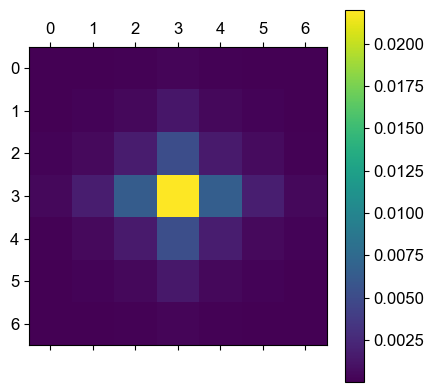

PyObject <matplotlib.colorbar.Colorbar object at 0x7f051e721290>

In [49]:
matshow((M1dat[1, 10, 10, 10, 4, :, :]^2 .+ M2dat[1, 10, 10, 10, 4, :, :]^2 .+ M3dat[1, 10, 10, 10, 4, :, :]^2))
colorbar()

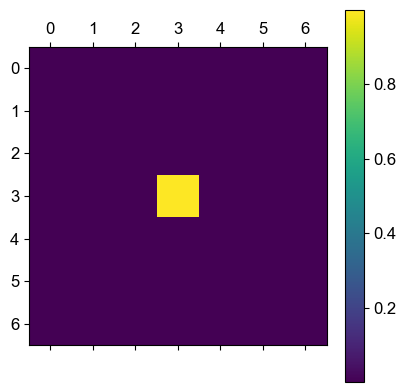

PyObject <matplotlib.colorbar.Colorbar object at 0x7f051e8adc90>

In [42]:
matshow((M1dat[2, 7, 7, 7, 4, :, :]^2 .+ M2dat[2, 7, 7, 7, 4, :, :]^2 .+ M3dat[2, 7, 7, 7, 4, :, :]^2)*4.41*4)
colorbar()

In [9]:
nx = 4
ny = 4
nz = 4
k_r = [0.2, 0.2, 0.2]
data = zeros(size(ks)[1], size(ks)[1], size(ks)[1])
for i in 1:size(ks)[1]
    for j in 1:size(ks)[1]
        for k in size(ks)[1]
            ik = round.(k_r.*((Nk-1)/1.5) .+ ((Nk+1)/2))
            k0_rounded = (ik.-((Nk+1)/2)) ./ ((Nk-1)/1.5)
            k0x, k0y, k0z = k0_rounded
        end
    end
end
kz = data[10]
pcolormesh([D_wdpl_fs.Mspline[1, nx, ny, nz, 1](kx, ky, kz).^2 .+ D_wdpl_fs.Mspline[1, nx, ny, nz, 2](kx, ky, kz).^2 .+ D_wdpl_fs.Mspline[1, nx, ny, nz, 3](kx, ky, kz).^2 for kx in data, ky in data])
colorbar()

LoadError: OutOfMemoryError()

In [10]:
θtest = 0.29635
ϕtest1 = -0.0004
ϕtest2 = 0.000325
println("rate left: ", string(dΓdωdΩ_stitch_FCC(ωp - ωi, θtest, ϕtest1, gvec, P, D_fcc, χ, np, L, 3, 1, lz=0.2e14)*cos(θtest)))
println("rate right: ", string(dΓdωdΩ_stitch_FCC(ωp - ωi, θtest, ϕtest2, gvec, P, D_fcc, χ, np, L, 3, 1, lz=0.2e14)*cos(θtest)))
info1 = info_stitch_FCC(ωp - ωi, θtest, ϕtest1, gvec, P, D_fcc, χ, np, L, 4, 1, 0.2e14)
info2 = info_stitch_FCC(ωp - ωi, θtest, ϕtest2, gvec, P, D_fcc, χ, np, L, 4, 1, 0.2e14)
println("G offset l: ", string(info1[1]))
println("G offset r: ", string(info2[1]))
println("k0 l: ", string(info1[2]))
println("k0 r: ", string(info2[2]))
println("k in 1BZ in recip. lattice coords, l: ", string(info1[3]))
println("k in 1BZ in recip. lattice coords, r: ", string(info2[3]))
println("M0, l: ", string(info1[4]))
println("M0, r: ", string(info2[4]))
println("ωi, l: ", string(info1[5]))
println("ωi, r: ", string(info2[5]))

LoadError: UndefVarError: D_fcc not defined

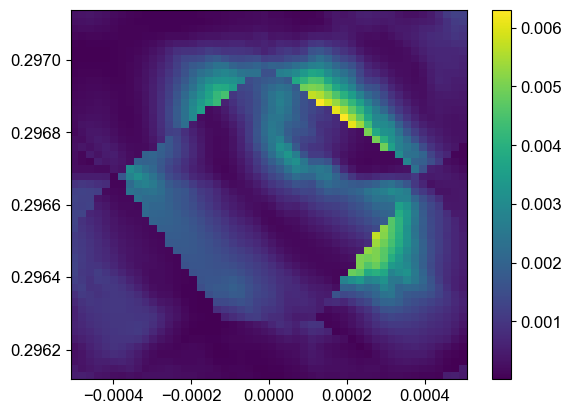

PyObject <matplotlib.colorbar.Colorbar object at 0x7fae5b3b4b10>

In [278]:
ωi = 1.2/ħeV #2/ħeV
Nangles = 50
θdev = 0.0005
ϕdev = 0.0005
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
# Threads.@threads for b in 1:Nb
#     newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, lz=0.2e14)*cos(θs)
#                         for θs in θrange, ϕs in ϕrange]
#     global dat .+= newdat
# end
dat = [info_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, 3, 1, 0.2e14)[4]^2 + 
       info_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, 4, 1, 0.2e14)[4]^2 for θs in θrange, ϕs in ϕrange]

dat_fcc_med = dat

pcolormesh(ϕrange, θrange, dat)
colorbar()
# PyPlot.contour(ϕrange, θrange, colors1m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors2m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors3m, levels=-5.5:5.5, colors=["white"])

In [201]:
println("M0: $(dat3[4])")
println("M0 nn: $(dat_nn3[4])")
println("k_r: $(dat3[3])")
println("kr_rounded: $(dat_nn3[7])")
println("offset: $(dat3[1])")
println("offset nn: $(dat_nn3[1])")

M0: 0.008110449463962919
M0 nn: 0.00797685914435667
k_r: [0.0056705495203700496, 0.008983957677979104, -0.27220006480231296]
kr_rounded: [0.0, 0.0, -0.3214285714285714]
offset: [0, 1, 0]
offset nn: [0, 1, 0]


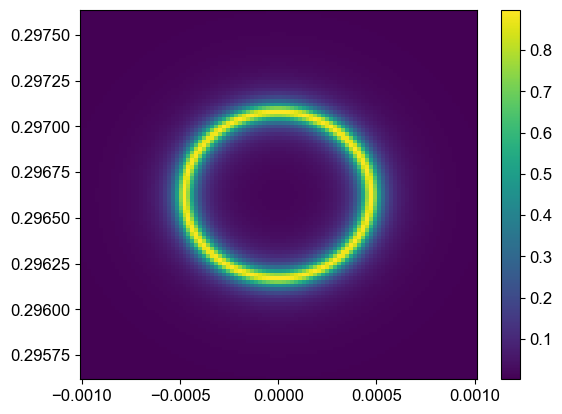

PyObject <matplotlib.colorbar.Colorbar object at 0x7f299c1405d0>

In [155]:
ωi = 0.9/ħeV #2/ħeV
Nangles = 100
θdev = 0.001
ϕdev = 0.001
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
# Threads.@threads for b in 3:3
#     newdat = [dΓdωdΩ_stitch_FCC_nn(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, lz=1.2e14)*cos(θs)*2
#                         for θs in θrange, ϕs in ϕrange]
#     global dat .+= newdat
# end

# return offset, [kB0x, kB0y, kB0z], k_r, M02, ωi, lor(ωp - ωs - ωi, lz), k0_rounded
# Threads.@threads for b in 5:5
#     newdat = [info_stitch_FCC_nn(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, 0.2e14)[4] 
#         for θs in θrange, ϕs in ϕrange]
#     global dat .+= newdat
# end
# subplots(1,2, figsize=(12, 5))
# subplot(1,2,1)
# title("Mode integral, band 5")
# pcolormesh(ϕrange, θrange, dat)
# colorbar()

dat2 = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0,0,1], P, 12, χ, np, L, pol="te", lz=1.2e14)*cos(θs)
        + dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0,0,1], P, 12, χ, np, L, pol="tm", lz=1.2e14)*cos(θs))
                    for θs in θrange, ϕs in ϕrange]

# subplot(1,2,2)
# title("analytical solution")
pcolormesh(ϕrange, θrange, dat2)
colorbar()

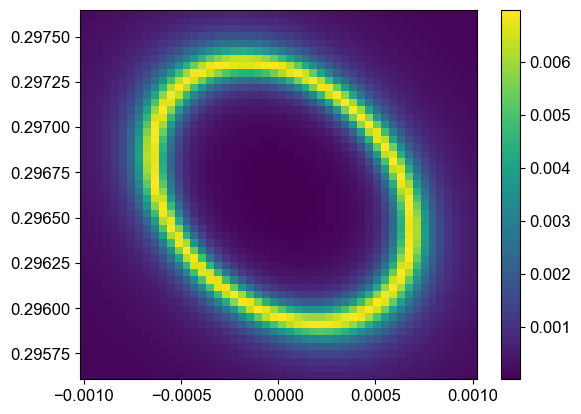

PyObject <matplotlib.colorbar.Colorbar object at 0x7f599ba44bd0>

In [138]:
ωi = 0.3/ħeV #2/ħeV
Nangles = 50
θdev = 0.001
ϕdev = 0.001
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC_1(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, lz=1e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

# return offset, [kB0x, kB0y, kB0z], k_r, M02, ωi, lor(ωp - ωs - ωi, lz), k0_rounded
# dat = [info_stitch_FCC_nn(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, 1, 1, 0.2e14)[4] 
#         for θs in θrange, ϕs in ϕrange]

pcolormesh(ϕrange, θrange, dat)
colorbar()

In [161]:
Nangles = 300
θdev = 0.001
ϕdev = 0.001
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
npzwrite("phc_an_files/ang_spec_wdpl_ga_thrange.npz", θ)
npzwrite("phc_an_files/ang_spec_wdpl_ga_phrange.npz", ϕrange)

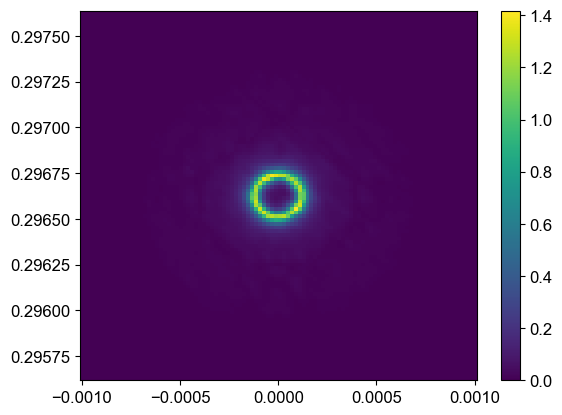

PyObject <matplotlib.colorbar.Colorbar object at 0x7f051d90e2d0>

In [72]:
ωi = 0.4/ħeV #2/ħeV
Nangles = 100
θdev = 0.001
ϕdev = 0.001
dat_fs = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_wdpl_fs, χ, np, L, b, 1, lz=1e14)*cos(θs)*2
                        for θs in θrange, ϕs in ϕrange]
    global dat_fs .+= newdat
end
# dat = [info_stitch_FCC_nn(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, 1, 1, 0.2e14)[1][3]
#                         for θs in θrange, ϕs in ϕrange]

pcolormesh(ϕrange, θrange, dat_fs)
colorbar()

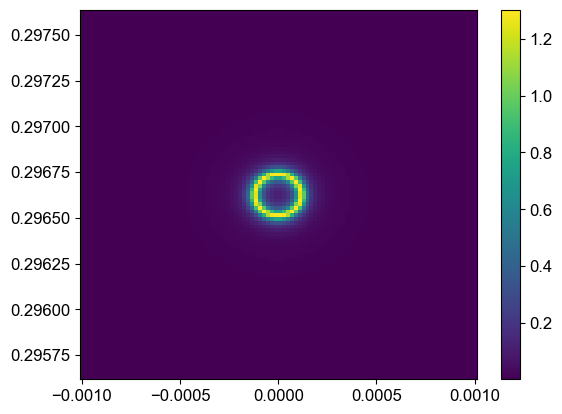

PyObject <matplotlib.colorbar.Colorbar object at 0x7f051d99b810>

In [70]:
dat2 = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0,0,1], P, 4.41, χ, np, L, pol="te", lz=1e14)*cos(θs)
        + dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0,0,1], P, 4.41, χ, np, L, pol="tm", lz=1e14)*cos(θs))
                    for θs in θrange, ϕs in ϕrange]

# subplot(1,2,2)
# title("analytical solution")
pcolormesh(ϕrange, θrange, dat2)
colorbar()

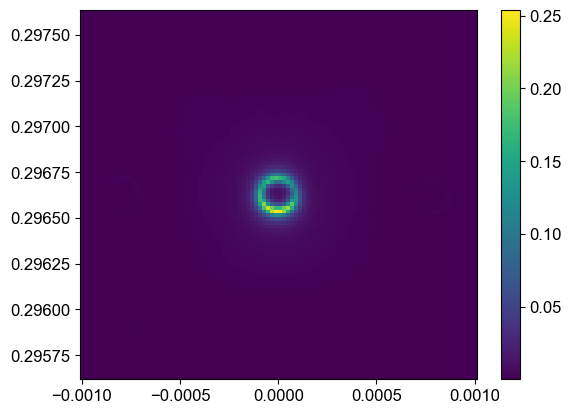

PyObject <matplotlib.colorbar.Colorbar object at 0x7f051e225890>

In [55]:
dat = zeros(Nangles,Nangles)
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_wdpl_ga, χ, np, L, b, 1, lz=1e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# dat = 
pcolormesh(ϕrange, θrange, dat)
colorbar()

In [73]:
println(sum(dat_fs))
println(sum(dat))
println(sum(dat2))

226.3795226666423
24.83403598258714
182.75499164784168


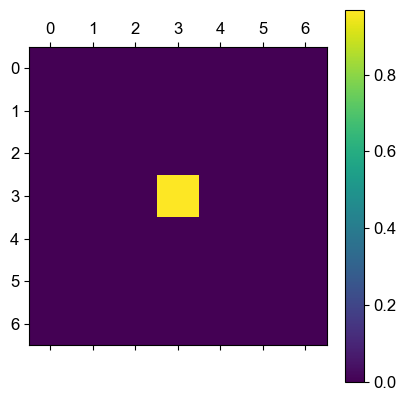

0.9682791807611196


In [67]:
matshow([sum([D_wdpl_fs.Mspline[2, 4, i, j, n](0.2, 0.2, 0.2)^2 for n in 1:3]) for i in 1:7, j in 1:7]*4.41*4)
colorbar()
println(sum([sum([D_wdpl_fs.Mspline[2, k, i, j, n](0.2, 0.2, 0.2)^2 for n in 1:3]) for i in 1:7, j in 1:7, k in 1:7])*4.41*4)

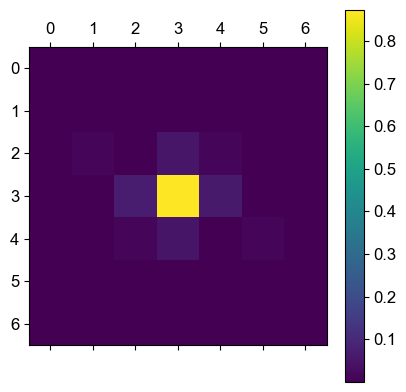

1.8393122451681045


In [68]:
matshow([sum([D_wdpl_ga.Mspline[1, 4, i, j, n](0.1, 0.1, 0.1)^2 for n in 1:3]) for i in 1:7, j in 1:7]*12*4)
colorbar()
println(sum([sum([D_wdpl_ga.Mspline[1, k, i, j, n](0.1, 0.1, 0.1)^2 for n in 1:3]) for i in 1:7, j in 1:7, k in 1:7])*12*4)

In [135]:
# npzwrite("phc_an_files/ang_spec_wdpl_ga_1-6_2.npz", dat)

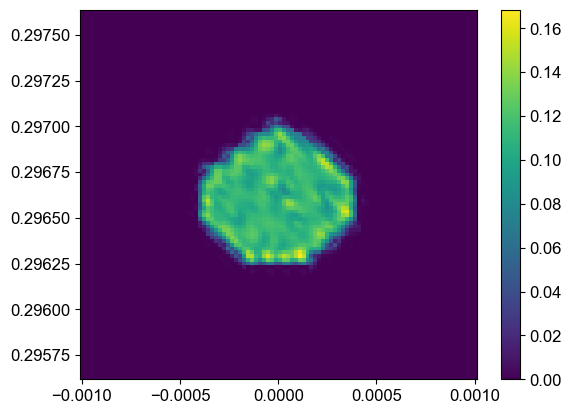

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa5f62b3190>

In [135]:
ωi = 0.4/ħeV #2/ħeV
Nangles = 100
θdev = 0.001
ϕdev = 0.001
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02, M022
Threads.@threads for b in 1:2
    newdat = [info_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_wdpl_fs, χ, np, L, b, 1, 0.2e14)[8]
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

pcolormesh(ϕrange, θrange, dat)
colorbar()

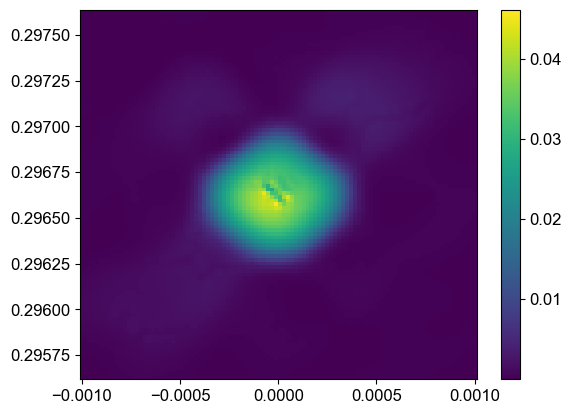

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa5f61fd310>

In [136]:
dat = zeros(Nangles,Nangles)
# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02, M022
Threads.@threads for b in 1:2
    newdat = [info_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_wdpl_ga, χ, np, L, b, 1, 0.2e14)[8]
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

pcolormesh(ϕrange, θrange, dat)
colorbar()

In [186]:
D_wdpl_fs.Msplines

0.0

In [137]:
# npzwrite("phc_an_files/ang_spec_wdpl_ga_0-7_2.npz", dat)

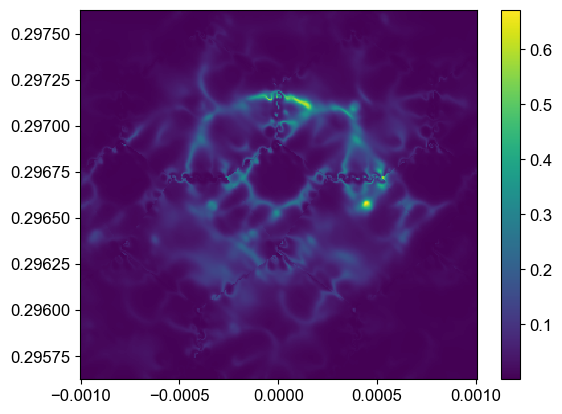

PyObject <matplotlib.colorbar.Colorbar object at 0x7f299c83e750>

In [140]:
ωi = 2.0/ħeV #2/ħeV
Nangles = 300
θdev = 0.001
ϕdev = 0.001
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, lz=0.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

pcolormesh(ϕrange, θrange, dat)
colorbar()
# PyPlot.contour(ϕrange, θrange, colors1m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors2m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors3m, levels=-5.5:5.5, colors=["white"])
# println(sum(dat))

In [141]:
npzwrite("phc_an_files/ang_spec_wdpl_ga_2-0_2.npz", dat)

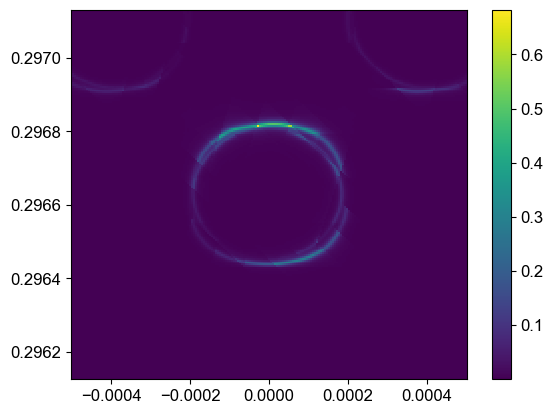

3.0874838239352633


In [228]:
ωi = 0.8/ħeV #2/ħeV
Nangles = 200
θdev = 0.0005
ϕdev = 0.0005
dat_nn = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC_nn(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, lz=0.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat_nn .+= newdat
end

pcolormesh(ϕrange, θrange, dat_nn)
colorbar()
# PyPlot.contour(ϕrange, θrange, colors1m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors2m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors3m, levels=-5.5:5.5, colors=["white"])
println(sum(dat))

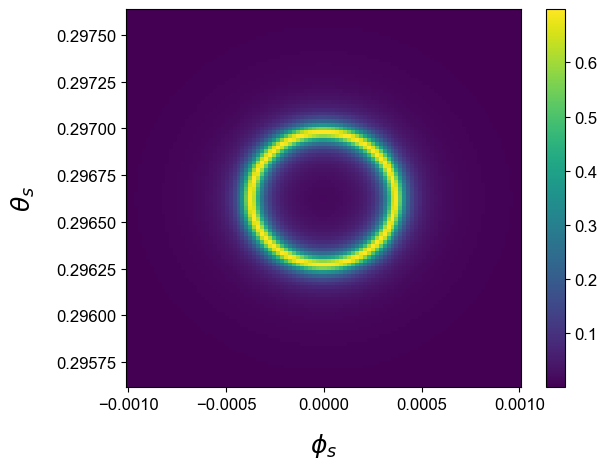

In [47]:
ωi = 0.7/ħeV #2/ħeV
Nangles = 100
# dat2 = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

#    1              2       3  4    5    6     7       8      9
# noffset, k0_vec_no_unit, M0, ωi, lor, Ep2, prefac, kbvec, Msplines
dat2 = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0,0,1], P, 12, χ, np, L, pol="te", lz=1.2e14)*cos(θs)
        + dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0,0,1], P, 12, χ, np, L, pol="tm", lz=1.2e14)*cos(θs))
                    for θs in θrange, ϕs in ϕrange]
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]


pcolormesh(ϕrange, θrange, dat2)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()
tight_layout()

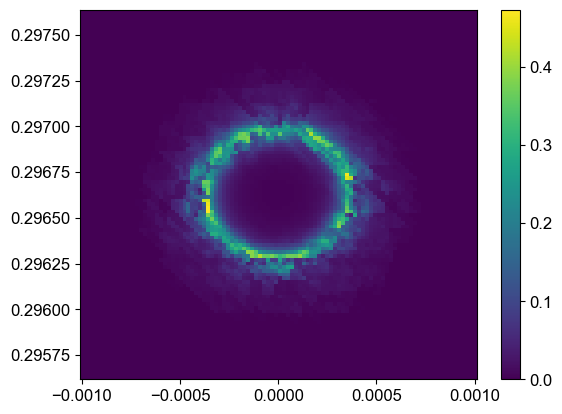

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa602820a10>

In [49]:
ωi = 0.7/ħeV #2/ħeV
Nangles = 100
θdev = 0.001
ϕdev = 0.001
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC_nn(ωp - ωi, θs, ϕs, gvec, P, D_wdpl_fs, χ, np, L, b, 1, lz=1.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

pcolormesh(ϕrange, θrange, dat)
colorbar()
# PyPlot.contour(ϕrange, θrange, colors1m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors2m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors3m, levels=-5.5:5.5, colors=["white"])
# println(sum(dat))

In [48]:
println(sum(dat2))
println(sum(dat))

523.9965000168601
219.74844646328728


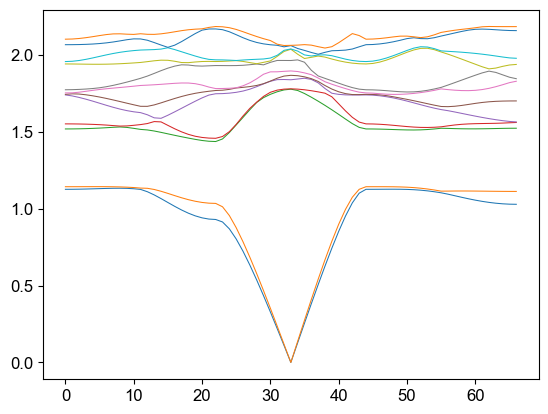

12-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f29a5915290>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a5920e50>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a5930c50>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a5930cd0>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a5930d90>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a5930ed0>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a5930f90>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a593e090>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a5930dd0>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a5930e90>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a5979e90>
 PyObject <matplotlib.lines.Line2D object at 0x7f29a593e2d0>

In [112]:
bands_sc = npzread("phc_an_files/phc3d_wdpl_bands_e_13_12b.npz")["arr_0"]
plt.plot(bands_sc* 2π* c /0.5e-6 * ħeV)
# plt.xticks([0, 9, 18, 27], ["M", "Gamma", "X", "M"])

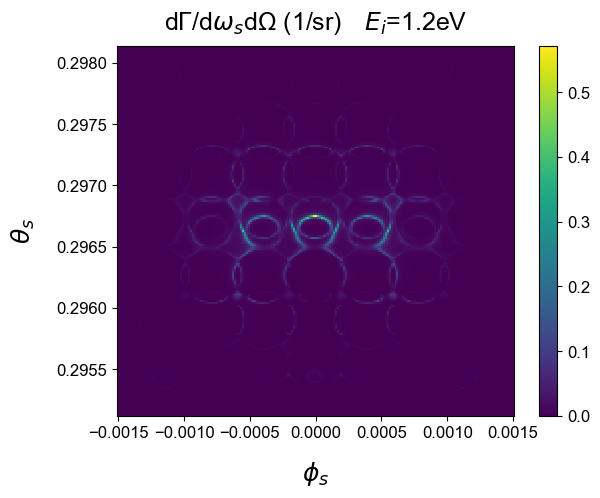

185.26981512680766


In [106]:
ωi = 1.3/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, b)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# noffset, k0_vec_no_unit, M02, ωi, lor, Ep2, prefactor, kBvec, [Msplines[i](k0x, k0y, k0z) for i in 1:3]
# dat = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 2)[3]
#                         for θs in θrange, ϕs in ϕrange]

pcolormesh(ϕrange, θrange, dat)
title(L"dΓ/d$ω_s$dΩ (1/sr) $~~E_i$=1.2eV", fontsize=18.0, pad=12)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar();
println(sum(dat))

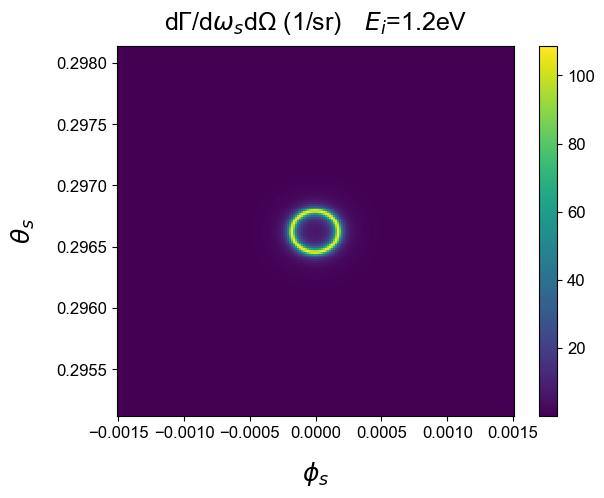

39257.45481515481


In [107]:
ωi = 1.3/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θdev = 0.0015
ϕdev = 0.0015
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0, 0, 1], P, ϵ_sc_sph, χ, np, L, pol="te", lz=1.2e14)*cos(θs) + 
           dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0, 0, 1], P, ϵ_sc_sph, χ, np, L, pol="tm", lz=1.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# noffset, k0_vec_no_unit, M02, ωi, lor, Ep2, prefactor, kBvec, [Msplines[i](k0x, k0y, k0z) for i in 1:3]
# dat = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 2)[3]
#                         for θs in θrange, ϕs in ϕrange]

dat_fcc_low = dat
pcolormesh(ϕrange, θrange, dat)
title(L"dΓ/d$ω_s$dΩ (1/sr) $~~E_i$=1.2eV", fontsize=18.0, pad=12)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar();
println(sum(dat))


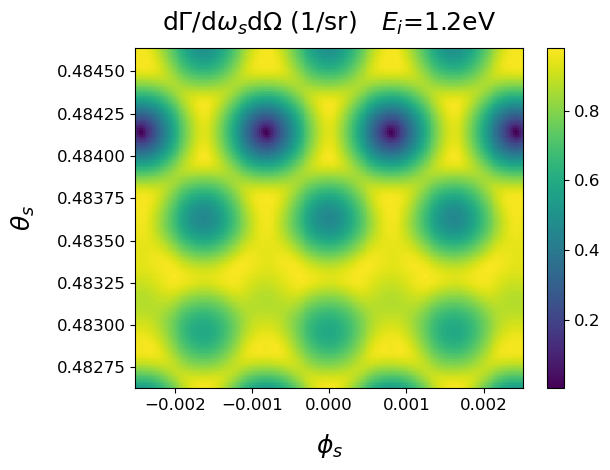

In [62]:
ωi = 1/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
# Threads.@threads for b in 1:Nb
#     newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc_25, χ, np, L, b)*sin(θs)
#                         for θs in θrange, ϕs in ϕrange]
#     global dat .+= newdat
# end
dat = [info_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_dmnd_25, χ, np, L, 2)[5]*ħeV
                        for θs in θrange, ϕs in ϕrange]

dat_fcc_high = dat

pcolormesh(ϕrange, θrange, dat)
title(L"dΓ/d$ω_s$dΩ (1/sr) $~~E_i$=1.2eV", fontsize=18.0, pad=12)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()
tight_layout()

## Create BZ boundaries
### SC

In [74]:
ωs = ωp - 0.5/ħeV
θyl = [c/(ωs*sin(θB))*(π/a + 2π*n/a) for n in -4:3] #for y
θzl = [acos(-c/(ωs)*(π/a + 2*n*π/a) + ωp/ωs * cos(θB)) for n in -2:2]
θxl = [asin(-*(1+2*n)*π*c/(ωs*a) - ωp/ωs * sin(θB) + g*c/ωs) for n in -4:4]

ωs = ωp - 0.8/ħeV
θym = [c/(ωs*sin(θB))*(π/a + 2π*n/a) for n in -4:3] #for y
θzm = [acos(-c/(ωs)*(π/a + 2*n*π/a) + ωp/ωs * cos(θB)) for n in -2:2]
θxm = [asin(-*(1+2*n)*π*c/(ωs*a) - ωp/ωs * sin(θB) + g*c/ωs) for n in -4:4]

ωs = ωp - 1.7/ħeV
θyh = [c/(ωs*sin(θB))*(π/a + 2π*n/a) for n in -4:3] #for y
θzh = [acos(-c/(ωs)*(π/a + 2*n*π/a) + ωp/ωs * cos(θB)) for n in -2:2]
θxh = [asin(-*(1+2*n)*π*c/(ωs*a) - ωp/ωs * sin(θB) + g*c/ωs) for n in -4:4];

In [15]:
colors1l = zeros(Nangles, Nangles)
colors2l = zeros(Nangles, Nangles)
colors3l = zeros(Nangles, Nangles)
# θrange = range(θB - θdev, θB + θdev, length=Nangles)
# ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
ωi = 0.4/ħeV
ωs = ωp - ωi

for (i, θs) in enumerate(θrange)
    for (j, ϕs) in enumerate(ϕrange)
        
        kBx = -ωs/c*sin(θs) - ωp/c*sin(θB) + gvec[3]
        kBy = -ωs/c*cos(θs)*sin(ϕs) + gvec[2]
        kBz = - ωs/c*cos(θs)*cos(ϕs) + ωp/c*cos(θB) + gvec[1]

        kBvec = [kBx, kBy, kBz]# .+ Goffset # in meters

        k0_vec_no_unit = (kBvec * a / (2π) .+ 100.5) .% 1 .- 0.5 # in MPB units

        offset = -floor.(kBvec*a/(2π) .+ 0.5)
        colors1l[i, j] = offset[1]
        colors2l[i, j] = offset[2]
        colors3l[i, j] = offset[3]
    end
end

# colors1m = zeros(Nangles, Nangles)
# colors2m = zeros(Nangles, Nangles)
# colors3m = zeros(Nangles, Nangles)
# ωi = 1/ħeV
# ωs = ωp - ωi

# for (i, θs) in enumerate(θrange)
#     for (j, ϕs) in enumerate(ϕrange)
#         kB0x = (-ωs/c*sin(θs)*cos(ϕs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
#         kB0y = -ωs/c*sin(θs)*sin(ϕs)*a/(2π)
#         kB0z = (-ωs/c*cos(θs) + ωp/c*cos(θB))*a/(2π)
#         offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
#         colors1m[i, j] = offset[1]
#         colors2m[i, j] = offset[2]
#         colors3m[i, j] = offset[3]
#     end
# end

# colors1h = zeros(Nangles, Nangles)
# colors2h = zeros(Nangles, Nangles)
# colors3h = zeros(Nangles, Nangles)
# ωi = 1.75/ħeV
# ωs = ωp - ωi

# for (i, θs) in enumerate(θrange)
#     for (j, ϕs) in enumerate(ϕrange)
#         kB0x = (-ωs/c*sin(θs)*cos(ϕs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
#         kB0y = -ωs/c*sin(θs)*sin(ϕs)*a/(2π)
#         kB0z = (-ωs/c*cos(θs) + ωp/c*cos(θB))*a/(2π)
#         offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
#         colors1h[i, j] = offset[1]
#         colors2h[i, j] = offset[2]
#         colors3h[i, j] = offset[3]
#     end
# end

### BCC/FCC

In [142]:
# create the BZ distinctions
# Nangles = 100
colors1l = zeros(Nangles, Nangles)
colors2l = zeros(Nangles, Nangles)
colors3l = zeros(Nangles, Nangles)
# θdev = 0.002
# ϕdev = 0.002
# θrange = range(θB - θdev, θB + θdev, length=Nangles)
# ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
ωi = 0.7/ħeV
ωs = ωp - ωi

for (i, θs) in enumerate(θrange)
    for (j, ϕs) in enumerate(ϕrange)
        kB0x = (-ωs/c*sin(θs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
        kB0y = (-ωs/c*cos(θs)*sin(ϕs) + gvec[2])*a/(2π)
        kB0z = (-ωs/c*cos(θs)*cos(ϕs) + ωp/c*cos(θB) + gvec[3])*a/(2π)
        offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
        colors1l[i, j] = offset[1]
        colors2l[i, j] = offset[2]
        colors3l[i, j] = offset[3]
    end
end

colors1m = zeros(Nangles, Nangles)
colors2m = zeros(Nangles, Nangles)
colors3m = zeros(Nangles, Nangles)
kb0xs = zeros(Nangles, Nangles)
kb0ys = zeros(Nangles, Nangles)
kb0zs = zeros(Nangles, Nangles)

ωi = 1.6/ħeV
ωs = ωp - ωi

for (i, θs) in enumerate(θrange)
    for (j, ϕs) in enumerate(ϕrange)
        kB0x = (-ωs/c*sin(θs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
        kB0y = (-ωs/c*cos(θs)*sin(ϕs) + gvec[2])*a/(2π)
        kB0z = (-ωs/c*cos(θs)*cos(ϕs) + ωp/c*cos(θB) + gvec[3])*a/(2π)
        kb0xs[i, j] = kB0x
        kb0ys[i, j] = kB0y
        kb0zs[i, j] = kB0z

#         kBx = (-ωs/c*sin(θs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
#         kBy = (-ωs/c*cos(θs)*sin(ϕs) + ωp/c*cos(θB)*sin(0) + gvec[2])*a/(2π)
#         kBz = (-ωs/c*cos(θs)*cos(ϕs) + ωp/c*cos(θB)*cos(0) + gvec[3])*a/(2π)

        offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
        colors1m[i, j] = offset[1]
        colors2m[i, j] = offset[2]
        colors3m[i, j] = offset[3]
    end
end

colors1h = zeros(Nangles, Nangles)
colors2h = zeros(Nangles, Nangles)
colors3h = zeros(Nangles, Nangles)
ωi = 2.0/ħeV
ωs = ωp - ωi

for (i, θs) in enumerate(θrange)
    for (j, ϕs) in enumerate(ϕrange)
        kB0x = (-ωs/c*sin(θs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
        kB0y = (-ωs/c*cos(θs)*sin(ϕs) + gvec[2])*a/(2π)
        kB0z = (-ωs/c*cos(θs)*cos(ϕs) + ωp/c*cos(θB) + gvec[3])*a/(2π)
        offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
        colors1h[i, j] = offset[1]
        colors2h[i, j] = offset[2]
        colors3h[i, j] = offset[3]
    end
end


In [143]:
colorsdict = Dict("1l"=>colors1l, "2l"=>colors2l, "3l"=>colors3l, "1m"=>colors1m, "2m"=>colors2m, "3m"=>colors3m, "1h"=>colors1h, "2h"=>colors2h, "3h"=>colors3h)
npzwrite("phc_an_files/bz_bounds_wdpl_Nang_300_12-11-23.npz", colorsdict)

In [128]:
?npzwrite

search: npzwrite



No documentation found.

`NPZ.npzwrite` is a `Function`.

```
# 2 methods for generic function "npzwrite":
[1] npzwrite(filename::AbstractString, vars::Dict{var"#s20",V} where V where var"#s20"<:AbstractString) in NPZ at /home/elinas/.julia/packages/NPZ/OBINJ/src/NPZ.jl:310
[2] npzwrite(filename::AbstractString, x) in NPZ at /home/elinas/.julia/packages/NPZ/OBINJ/src/NPZ.jl:304
```


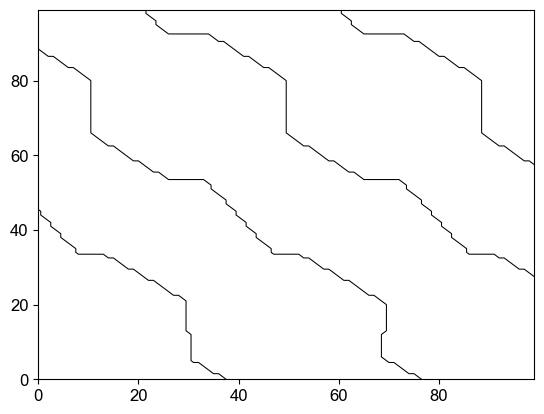

PyObject <matplotlib.contour.QuadContourSet object at 0x7f2a66b85550>

In [99]:
PyPlot.contour(colors2m, levels=-5.5:5.5, colors=["black"])

In [12]:
function dΓdωdΩ_stitch_FCC_nn(ωs::AbstractFloat, θs::AbstractFloat, ϕs::AbstractFloat, gvec, P::PumpBeam, D::PhC_Data, χ::AbstractFloat, np::AbstractFloat, L::AbstractFloat, band::Integer, ϵbg::Real=1; lz::AbstractFloat=0.2e14)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a
    g = gvec[1] #assuming in the x direction
    
    kBx = -ks*sin(θs) - kp*sin(θp) + gvec[1]
    kBy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kBz = -ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[3]
    
    kBvec = [kBx, kBy, kBz]
    
    kB0x = kBx * a / (2π)
    kB0y = kBy * a / (2π)
    kB0z = kBz * a / (2π)
    
    # k_r and offset both in recip lattice basis
    k_r, offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)
#     k_r0 = cartesian_to_BCC_recip * [kB0x, kB0y, kB0z]
#     k_r = collect(ms.first_brillouin_zone(mp.Vector3(k_r0[1], k_r0[2], k_r0[3])))
#     offset = k_r .- k_r0
    kcart = FCC_to_cartesian_recip * k_r
    if abs(k_r[1]) > 0.75 || abs(k_r[2]) > 0.75 || abs(k_r[3]) > 0.75
        println("k in FCC basis is > 0.75")
#         println(k_r)
#         println(FCC_to_cartesian_recip * k_r)
#         println(in_1BZ_FCC(FCC_to_cartesian_recip * k_r))
        return 0
    end
    
    if abs(offset[1]) > 3 || abs(offset[2]) > 3 || abs(offset[3]) > 3
#         println("offset is too much")
#         println(offset)
        return 0
    end
    
    n1, n2, n3 = -offset .+ [4,4,4]
    g_fcc = cartesian_to_FCC_recip * [1,0,0]
#     println(g_fcc)
    Msplines = [D.Mspline[band, Integer(n1), Integer(n2), Integer(n3),i] for i in 1:3]
    ωspline = D.ωspline[band]

    ω0 = ωspline(k_r[1], k_r[2], k_r[3])
    
#     k0_vec_no_unit = [kB0x, kB0y, kB0z]
#     k0_vec_no_unit = (kBvec * a / (2π) .+ 100.5) .% 1 .- 0.5
    ik = round.(k_r.*((Nk-1)/1.5) .+ ((Nk+1)/2))
    k0_rounded = (ik.-((Nk+1)/2)) ./ ((Nk-1)/1.5)
    k0x, k0y, k0z = k0_rounded
    M02 = sum([D.Mspline[band, Integer(n1), Integer(n2), Integer(n3), i](k0x, k0y, k0z) for i in 1:3].^2)

    ωi = ω0 * 2π*c / (sqrt(ϵbg)*a)

    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg)*Ep2 * L^3 * χ^2
    
    return prefactor * ωi * M02 * lor(ωp - ωs - ωi, lz)       
end

function dΓdωdΩ_stitch_FCC_1(ωs::AbstractFloat, θs::AbstractFloat, ϕs::AbstractFloat, gvec, P::PumpBeam, D::PhC_Data, χ::AbstractFloat, np::AbstractFloat, L::AbstractFloat, band::Integer, ϵbg::Real=1; lz::AbstractFloat=0.2e14)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a
    
    kBx = -ks*sin(θs) - kp*sin(θp) + gvec[1]
    kBy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kBz = -ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[3]
    
    kBvec = [kBx, kBy, kBz]
    
    kB0x = kBx * a / (2π)
    kB0y = kBy * a / (2π)
    kB0z = kBz * a / (2π)
    
    # k_r and offset both in recip lattice basis
    k_r, offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)
    kcart = FCC_to_cartesian_recip * k_r
    if abs(k_r[1]) > 0.75 || abs(k_r[2]) > 0.75 || abs(k_r[3]) > 0.75
        println("k in FCC basis is > 0.75")
        return 0
    end
    
    if abs(offset[1]) > 3 || abs(offset[2]) > 3 || abs(offset[3]) > 3
        return 0
    end
    
    n1, n2, n3 = -offset .+ [4,4,4]
    ωspline = D.ωspline[band]

    ω0 = ωspline(k_r[1], k_r[2], k_r[3])
    
    M02 = 0.0008
    
    ωi = ω0 * 2π*c / (sqrt(ϵbg)*a)

    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg)*Ep2 * L^3 * χ^2
    
    return prefactor * ωi * M02 * lor(ωp - ωs - ωi, lz)       
end

function info_stitch_FCC_nn(ωs, θs, ϕs, gvec, P::PumpBeam, D::PhC_Data, χ, np, L, band, ϵbg=1, lz=0.2e14)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a

    kBx = -ks*sin(θs) - kp*sin(θp) + gvec[1]
    kBy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kBz = -ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[3]
    kBvec = [kBx, kBy, kBz]
    
    kB0x = kBx * a / (2π)
    kB0y = kBy * a / (2π)
    kB0z = kBz * a / (2π)
    
    # k_r and offset both in recip lattice basis
    k_r, offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)
#     k_r0 = cartesian_to_BCC_recip * [kB0x, kB0y, kB0z]
#     k_r = collect(ms.first_brillouin_zone(mp.Vector3(k_r0[1], k_r0[2], k_r0[3])))
#     offset = k_r .- k_r0
    kcart = FCC_to_cartesian_recip * k_r
    if abs(k_r[1]) > 0.75 || abs(k_r[2]) > 0.75 || abs(k_r[3]) > 0.75
#         println("k in FCC basis is > 0.75")
        println(k_r)
#         println(FCC_to_cartesian_recip * k_r)
        println("is it in the 1BZ: ", in_1BZ_FCC(FCC_to_cartesian_recip * k_r))
        return [0,0,0],[0,0,0],[0,0,0],0,0,0,0
    end
    
#     BCC_basis_k = cartesian_to_BCC_recip * reshape(k0, 3, 1)
    
    if abs(offset[1]) > 3 || abs(offset[2]) > 3 || abs(offset[3]) > 3
        println("offset is too much")
        println(offset)
        println("k_r: ", k_r)
        println(kB0x)
        println(kB0y)
        println(kB0z)
        return [0,0,0],[kB0x, kB0y, kB0z],[0,0,0],0,0,0,0
    end
    
    n1, n2, n3 = -offset .+ [4,4,4]
    g_fcc = cartesian_to_FCC_recip * [1,0,0]
#     println(g_fcc)
#     Msplines = [D.Mspline[band, Integer(n1), Integer(n2), Integer(n3),i] for i in 1:3]
#     println(Msplines)
    ωspline = D.ωspline[band]

    ω0 = ωspline(k_r[1], k_r[2], k_r[3])
    ωi = ω0 * 2π*c / (sqrt(ϵbg)*a)
    
#     M0 = reshape([Msplines[i](k_r[1], k_r[2], k_r[3]) for i in 1:3], 1, 3) * reshape(g_fcc, 3, 1)
#     M0 = M0[1]
#     k0_vec_no_unit = (kBvec * a / (2π) .+ 100.5) .% 1 .- 0.5
    ik = round.(k_r.*((Nk-1)/1.5) .+ ((Nk+1)/2))    
    k0_rounded = (ik.-((Nk+1)/2)) ./ ((Nk-1)/1.5)
    k0x, k0y, k0z = k0_rounded
#     M0 = sum([Msplines[i](k0x, k0y, k0z) for i in 1:3].*normalize(gvec))
#     M0 = D.Mspline[band, Integer(n1), Integer(n2), Integer(n3), 1](k0x, k0y, k0z)

    M02 = sum([D.Mspline[band, Integer(n1), Integer(n2), Integer(n3), i](k0x, k0y, k0z) for i in 1:3].^2)
    
    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg) * Ep2 * L^3 * χ^2
    
    return offset, [kB0x, kB0y, kB0z], k_r, M02, ωi, lor(ωp - ωs - ωi, lz), k0_rounded
end

info_stitch_FCC_nn (generic function with 3 methods)

In [13]:
function dΓdωdΩ_stitch_FCC_rot(ωs::AbstractFloat, θs::AbstractFloat, ϕs::AbstractFloat, gvec, P::PumpBeam, D::PhC_Data, χ::AbstractFloat, np::AbstractFloat, L::AbstractFloat, band::Integer, ϵbg::Real=1; lz::AbstractFloat=0.2e14)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a
    
    kBx = (-ks*sin(θs)*cos(ϕs) - kp*sin(θp) + gvec[1])
    kBy = -ks*sin(θs)*sin(ϕs) + gvec[2]
    kBz = (-ks*cos(θs) + kp*cos(θp) + gvec[3])
    
    kB0x = kBx * a / (2π)
    kB0y = kBy * a / (2π)
    kB0z = kBz * a / (2π)
    
    
    # k_r and offset both in recip lattice basis
    k_r, offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)
#     k_r0 = cartesian_to_BCC_recip * [kB0x, kB0y, kB0z]
#     k_r = collect(ms.first_brillouin_zone(mp.Vector3(k_r0[1], k_r0[2], k_r0[3])))
#     offset = k_r .- k_r0
    kcart = FCC_to_cartesian_recip * k_r
    if abs(k_r[1]) > 0.75 || abs(k_r[2]) > 0.75 || abs(k_r[3]) > 0.75
        println("k in FCC basis is > 0.75")
#         println(k_r)
#         println(FCC_to_cartesian_recip * k_r)
#         println(in_1BZ_FCC(FCC_to_cartesian_recip * k_r))
        return 0
    end
    
#     BCC_basis_k = cartesian_to_BCC_recip * reshape(k0, 3, 1)
    
    if abs(offset[1]) > 3 || abs(offset[2]) > 3 || abs(offset[3]) > 3
#         println("offset is too much")
#         println(offset)
        return 0
    end
    
    n1, n2, n3 = -offset .+ [4,4,4]
    g_fcc = cartesian_to_FCC_recip * gvec
#     println(g_fcc)
    Msplines = [D.Mspline[band, Integer(n1), Integer(n2), Integer(n3),i] for i in 1:3]
#     println(Msplines)
    ωspline = D.ωspline[band]

    ω0 = ωspline(k_r[1], k_r[2], k_r[3])
    M0 = reshape([Msplines[i](k_r[1], k_r[2], k_r[3]) for i in 1:3], 1, 3) * reshape(normalize(g_fcc), 3, 1)
    M0 = M0[1]

    ωi = ω0 * 2π*c / (sqrt(ϵbg)*a)

    #return func
    
    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg)*Ep2 * L^3 * χ^2
    
    
    return prefactor * ωi * M0^2 * lor(ωp - ωs - ωi, lz)
    
        
end


dΓdωdΩ_stitch_FCC_rot (generic function with 2 methods)

## 3 panel figure

## Frequency spectrum
### Free space

In [101]:
ϵ_wdpl_gaas = 4.546 # from MPB
ϵ_sc_sph = 1.72
θdev = 0.0015
ϕdev = 0.0025

Nω = 10
Nangles = 175

θrange = range(θB - θdev/2, θB + θdev/2, length=Nangles)
ϕrange = range(-ϕdev/2, ϕdev/2, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

ωirange = range(0.01/ħeV, 1/ħeV, length=Nω)
dηdω_fs_sph = zeros(Nω)
dat = zeros(Nangles, Nangles)


for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = [dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0, 0, 1], P, ϵ_sc_sph, χ, np, L, pol="te", lz=1.2e14)*cos(θs) + 
           dΓdωdΩ_free(ωp - ωi, θs, ϕs, g*[0, 0, 1], P, ϵ_sc_sph, χ, np, L, pol="tm", lz=1.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    dηdω_fs_sph[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10


### Simple cubic

In [92]:
freq_spec_sc_sph = dηdω(10, 1.0, P, D_sc, "sc", gvec, χ, np, L, Nangles=80, θdev=0.0015, ϕdev=0.0015, lz=0.6e14)

phidev = 0.0018299169928324426
θp = 0.29662806479241327
omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10


10-element Array{Float64,1}:
 4.935318236746561e-25
 1.139989675085064e-24
 1.7427358204371533e-24
 2.552598808088129e-24
 4.312614211385002e-24
 6.0016138463768865e-24
 8.811551453751242e-24
 1.3034817603936269e-23
 1.9695691907230346e-23
 2.9095884562119216e-23

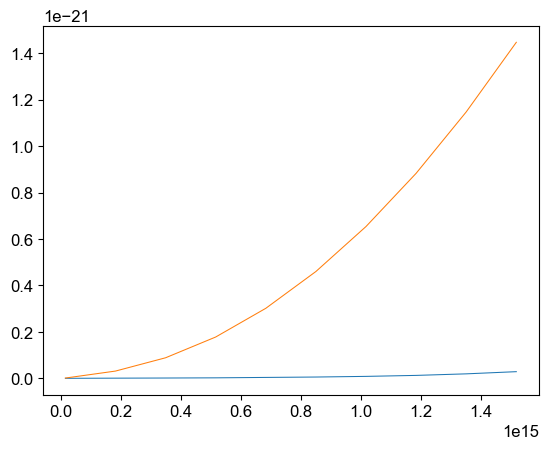

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa007874250>

In [103]:
plot(ωirange, freq_spec_sc_sph)
plot(ωirange, dηdω_fs_sph)

In [55]:
θdev = 0.001
ϕdev = 0.0025

Nω = 80
Nangles = 100

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

ωirange = range(0.01/ħeV, 2.55/ħeV, length=Nω)
dηdω_sc = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:12 # CHANGED DUE TO MORE BANDS
        newdat = [dΓdωdΩ_stitch(ωp - ωi, θs, ϕs, gvec, P, D_sc_15_12b, χ, np, L, b)*sin(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_sc[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50
omega i = 51
omega i = 52
omega i = 53
omega i = 54
omega i = 55
omega i = 56
omega i = 57
omega i = 58
omega i = 59
omega i = 60
omega i = 61
omega i = 62
omega i = 63
omega i = 64
omega i = 65
omega i = 66
omega i = 67
omega i = 68
omega i = 69
omega i = 70
omega i = 71
omega i = 72
omega i = 73
omega i = 74
omega i = 75
omega i = 76
omega i = 77
omega i 

### BCC

In [ ]:
θdev = 0.001
ϕdev = 0.0025

Nω = 50
Nangles = 100

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# ωirange_fs = range(0.01/ħeV, 1/ħeV, length=Nω)
dηdω_bcc = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:Nb
        newdat = [dΓdωdΩ_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc_21, χ, np, L, b)*sin(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_bcc[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

### FCC

In [ ]:
θdev = 0.001
ϕdev = 0.0025

Nω = 50
Nangles = 80

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# ωirange_fs = range(0.01/ħeV, 1/ħeV, length=Nω)
dηdω_fcc = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:Nb
        newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc_21, χ, np, L, b)*sin(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_fcc[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

### Woodpile

In [144]:
Nω = 80
dηdω_wdpl_gaas = dηdω(Nω, 2.25, P, D_fcc, "fcc", gvec, χ, np, L; Nangles=100, θdev=0.0015, ϕdev=0.0015, pol="te")
                 .+ dηdω(Nω, 2.25, P, D_fcc, "fcc", gvec, χ, np, L; Nangles=100, θdev=0.0015, ϕdev=0.0015, pol="tm")

phidev = 0.0018299169928324426
θp = 0.29662806479241327
omega i = 1


LoadError: TaskFailedException:
MethodError: no method matching dΓdωdΩ_stitch_FCC(::Float64, ::Float64, ::Float64, ::Array{Float64,1}, ::PumpBeam, ::PhC_Data, ::Float64, ::Float64, ::Float64, ::Int64, ::Int64; lz=2.0e13, pol="te")
Closest candidates are:
  dΓdωdΩ_stitch_FCC(::AbstractFloat, ::AbstractFloat, ::AbstractFloat, ::Any, ::PumpBeam, ::PhC_Data, ::AbstractFloat, ::AbstractFloat, ::AbstractFloat, ::Integer, ::Real; lz) at /home/elinas/Research/xray/xray_3dphc.jl:909 got unsupported keyword argument "pol"
  dΓdωdΩ_stitch_FCC(::AbstractFloat, ::AbstractFloat, ::AbstractFloat, ::Any, ::PumpBeam, ::PhC_Data, ::AbstractFloat, ::AbstractFloat, ::AbstractFloat, ::Integer) at /home/elinas/Research/xray/xray_3dphc.jl:909 got unsupported keyword arguments "lz", "pol"
Stacktrace:
 [1] kwerr(::NamedTuple{(:lz, :pol),Tuple{Float64,String}}, ::Function, ::Float64, ::Float64, ::Float64, ::Array{Float64,1}, ::PumpBeam, ::PhC_Data, ::Float64, ::Float64, ::Float64, ::Int64, ::Int64) at ./error.jl:157
 [2] (::var"#258#260"{Int64,Float64,String,PumpBeam,PhC_Data,Array{Float64,1},Float64,Float64,Float64,Float64})(::Tuple{Float64,Float64}) at ./none:0
 [3] iterate at ./generator.jl:47 [inlined]
 [4] collect(::Base.Generator{Base.Iterators.ProductIterator{Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}},var"#258#260"{Int64,Float64,String,PumpBeam,PhC_Data,Array{Float64,1},Float64,Float64,Float64,Float64}}) at ./array.jl:686
 [5] macro expansion at /home/elinas/Research/xray/xray_3dphc.jl:1092 [inlined]
 [6] (::var"#276#threadsfor_fun#259"{Float64,String,PumpBeam,PhC_Data,Array{Float64,1},Float64,Float64,Float64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Float64,UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:81
 [7] (::var"#276#threadsfor_fun#259"{Float64,String,PumpBeam,PhC_Data,Array{Float64,1},Float64,Float64,Float64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Float64,UnitRange{Int64}})() at ./threadingconstructs.jl:48

In [175]:
θdev = 0.0015
ϕdev = 0.00225

Nω = 10
Nangles = 80

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

ωirange = range(0.01/ħeV, 2.2/ħeV, length=Nω)
dηdω_wdpl_fs = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    global dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:Nb
        newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc_fs, χ, np, L, b, 1, lz=0.4e14)*cos(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_wdpl_fs[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)  
end

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10


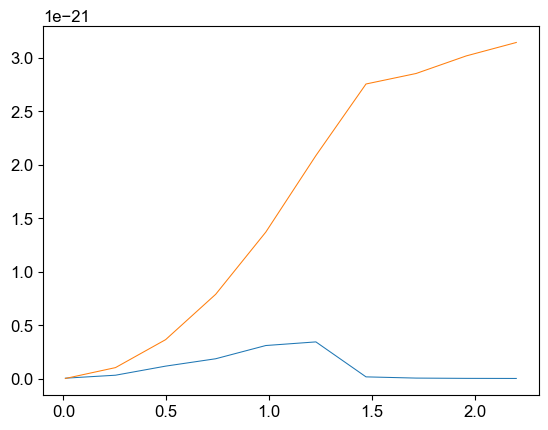

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f2be6b51210>

In [177]:
plot(ωirange*ħeV, dηdω_wdpl_fs)
plot(ωirange*ħeV, dηdω_fs_12)

In [150]:
npzwrite("phc_an_files/freq_spec_wdpl_gaas_12-11-23.npz", dηdω_wdpl)
npzwrite("phc_an_files/freq_spec_wdpl_gaas_fs_12-12-23.npz", dηdω_fs_wdpl_gaas)

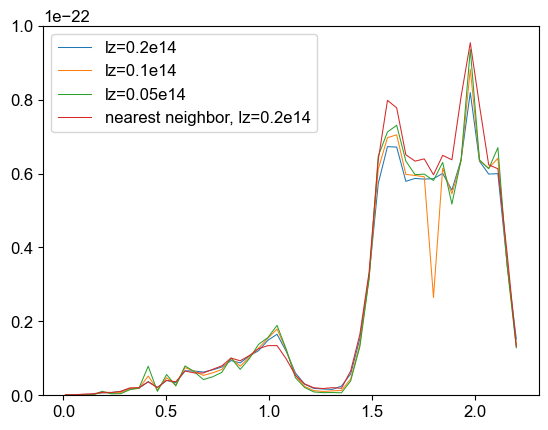

(0.0, 1.0e-22)

In [235]:
PyPlot.plot(ωirange*ħeV, dηdω_wdpl, label="lz=0.2e14")
# ylim(0,4e-28)
PyPlot.plot(ωirange*ħeV, dηdω_wdpl_n, label="lz=0.1e14")
PyPlot.plot(ωirange*ħeV, dηdω_wdpl_nr, label="lz=0.05e14")
PyPlot.plot(ωirange*ħeV, dηdω_wdpl_nn, label="nearest neighbor, lz=0.2e14")
PyPlot.legend()
PyPlot.ylim((0, 1e-22))

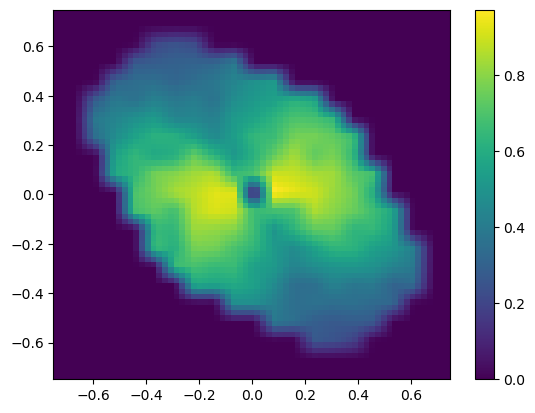

PyObject <matplotlib.colorbar.Colorbar object at 0x7fec1153cc50>

In [117]:
band = 1
nx = 4
ny = 4
nz = 4
kx = 0
ky = 0
kz = 0
ωitp = interpolate(ωdat[band,:,:,:], BSpline(Linear()));
ωsitp = scale(ωitp, krange, krange, krange);

Mitp = interpolate(M1dat[band,:,:,:,nx,ny,nz] .* ks_1BZ_BCC, BSpline(Linear()));
Msitp = scale(Mitp, krange, krange, krange);

ks = range(-0.749,0.749,length=70)
plotdat = [Msitp(kx, ky, kz) for kx in ks, ky in ks]

# plotdat = [D.Mspline[band, 4, 4, 4, 1](kx, ky, 0) for kx in ks, ky in ks]

Mitp = interpolate(M1dat[band + 1,:,:,:,nx,ny,nz] .* ks_1BZ_BCC, BSpline(Linear()));
Msitp = scale(Mitp, krange, krange, krange);

plotdat .+= [Msitp(kx, ky, kz) for kx in ks, ky in ks]

# plotdat .+= [D.Mspline[band + 1, 4, 4, 4, 1](kx, ky, 0) for kx in ks, ky in ks]
pcolormesh(ks, ks, plotdat)
colorbar()

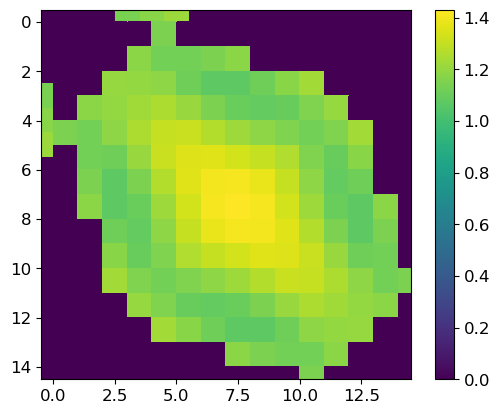

PyObject <matplotlib.colorbar.Colorbar object at 0x7f328322d750>

In [94]:
band = 3
nx = 4
ny = 4
nz = 4
kx = 0
ky = 0
kz = 0
ωitp = interpolate(ωdat[band,:,:,:], BSpline(Quadratic(Flat(OnCell()))));
ωsitp = scale(ωitp, krange, krange, krange);

Mitp = interpolate(M1dat[band,:,:,:,nx,ny,nz], BSpline(Linear()));
Msitp = scale(Mitp, krange, krange, krange);

ks = range(-0.49,0.49,length=70)
plotdat = [ωsitp(kx, ky, kz)* 2*π*c/a*ħeV for kx in krange, ky in krange]
pcolormesh(plotdat)
show()
plotdat = ωdat[band,7,:,:].*(2*π*c/a*ħeV)
imshow(plotdat)
show()

# plotdat = [D.Mspline[band, 4, 4, 4, 1](kx, ky, 0) for kx in ks, ky in ks]


colorbar()

In [14]:
ωs = zeros(70, 70)
for i in 1:69
    for j in 1:69
        k = bring_into_1BZ_BCC(ks[i], ks[j], 0.15)[1]
        ωs[i,j] = Msplines[2,4,4,4,1](k[1], k[2], k[3])^2 + Msplines[1,4,4,4,1](k[1], k[2], k[3])^2
    end
end
imshow(ωs)
colorbar()

LoadError: UndefVarError: Msplines not defined

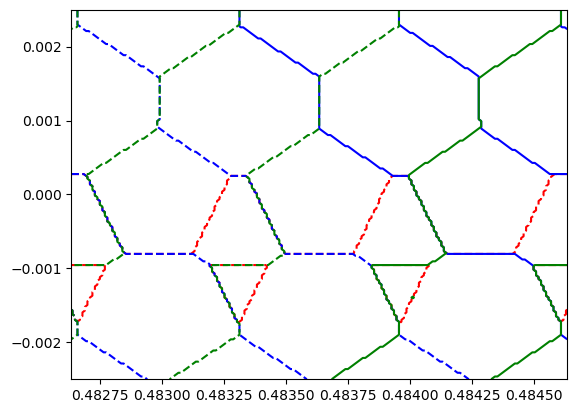

None of these options worked :'(
None of these options worked :'(


PyObject <matplotlib.contour.QuadContourSet object at 0x7f7042f5f2d0>

In [59]:
colors1 = zeros(Nangles, Nangles)
colors2 = zeros(Nangles, Nangles)
colors3 = zeros(Nangles, Nangles)

for (i, θs) in enumerate(θrange)
    for (j, ϕs) in enumerate(ϕrange)
        kB0x = (-ωs/c*sin(θs)*cos(ϕs) - ωp/c*sin(θB) + gvec[1])* D.a/(2π)
        kB0y = -ωs/c*sin(θs)*sin(ϕs)*D.a/(2π)
        kB0z = (-ωs/c*cos(θs) + ωp/c*cos(θB))*D.a/(2π)
        offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
        colors1[i, j] = offset[1]
        colors2[i, j] = offset[2]
        colors3[i, j] = offset[3]

    end
end
contour(θrange, ϕrange, colors1, levels=-5.5:5.5, colors=["red"])
contour(θrange, ϕrange, colors2, levels=-5.5:5.5, colors=["blue"])
contour(θrange, ϕrange, colors3, levels=-5.5:5.5, colors=["green"])


In [233]:
BCC_to_cartesian_recip * cartesian_to_BCC_recip

3×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [93]:
function zone_map(ωs, θs, ϕs, gvec, P::PumpBeam, D::PhC_Data, noffset)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a
    
#     nx, ny, nz = noffset .+ [4, 4, 4]
#     Mspline = D.Mspline[band, nx, ny, nz]
#     ωspline = D.ωspline[band]
    
#     kpvec = kp*[sin(θp)*cos(ϕp), sin(θp)*sin(ϕp), cos(θp)]
#     ksvec = ks*[sin(θs)*cos(ϕs), sin(θs)*sin(ϕs), cos(θs)]
    

#     k0vec = gvec .+ kpvec .- ksvec
    g = gvec[1] #assuming in the x direction
    Goffset = 2π/a * noffset #reciprocal lattice vector offset

    kBx = -ks*sin(θs)*cos(ϕs) - kp*sin(θp) + g
    kBy = -ks*sin(θs)*sin(ϕs)
    kBz = -ks*cos(θs) + kp*cos(θp)

    kBvec = [kBx, kBy, kBz] .+ Goffset

    k0_vec_no_unit = kBvec * a / (2π)
    return k0_vec_no_unit
end

zone_map (generic function with 1 method)

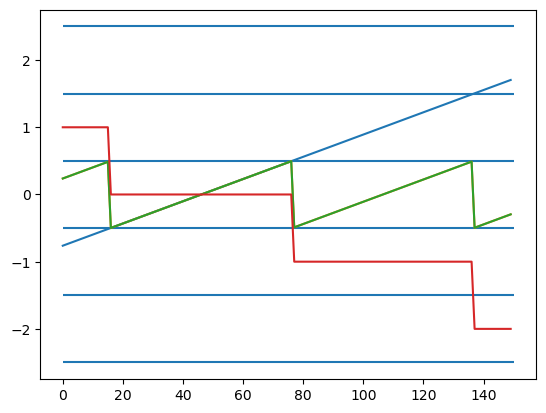

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6236c21210>

In [164]:
# Test of bringing k into 1BZ
kp = ωp/c
ks = ωs/c
ϕs = 0
kBs = zeros(Nangles)
ns = zeros(Nangles)
θx = [asin(-(1+2*n)*π*c/(ωs*a) - ωp/ωs * sin(θB) + g*c/ωs) for n in -5:5]
θy = [c/(ωs*sin(θB))*(π/a + 2π*n/a) for n in -5:5] #for y
θz = [acos(-c/(ωs)*(π/a + 2*n*π/a) + ωp/ωs * cos(θB)) for n in -5:5]
θs = θB
for (i, θs) in enumerate(θrange)
    kBx = -ks*sin(θs)*cos(ϕs) - kp*sin(θB) + g
    kBy = -ks*sin(θs)*sin(ϕs)
    kBz = -ks*cos(θs) + kp*cos(θB)
    kBs[i] = kBz
    
    ny = (bin(ϕs, θy) - 5)
    nx = bin(θs, reverse(θx)) - 6
    nz = -(bin(θs, θz) - 5)
    ns[i] = nz
end

plot(kBs*a/(2π))
plot(kBs*a/(2π) .+ ns)
plot((kBs*a/(2π) .+ 5.5) .% 1 .- 0.5)
hlines(-2.5:2.5, 0, Nangles)
plot(ns)

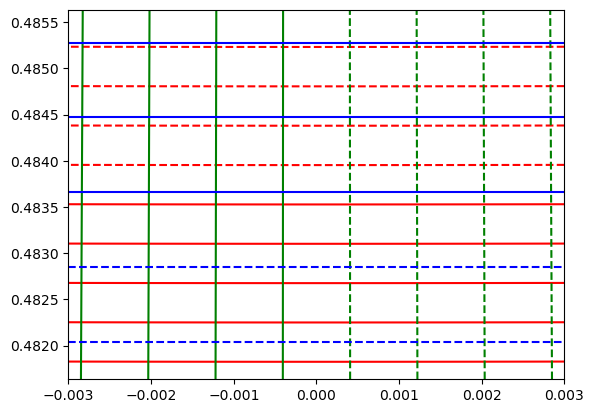

In [94]:
θrange = range(θB - 0.002, θB + 0.002, length=200)
ϕrange = range(-0.003, 0.003, length=200)

clist = ["red", "green", "blue"]

for dir in 1:3
    dat = [zone_map(ωp - ωi, θs, ϕs, gvec, P, D, [0,0,0])[dir]
                            for θs in θrange, ϕs in ϕrange]
    #pcolormesh(dat)
    contour(ϕrange, θrange, dat, levels=-5.5:5.5, colors=[clist[dir]])
end

# hlines(θx, minimum(ϕrange), maximum(ϕrange))
# vlines(θy, minimum(θrange), maximum(θrange))

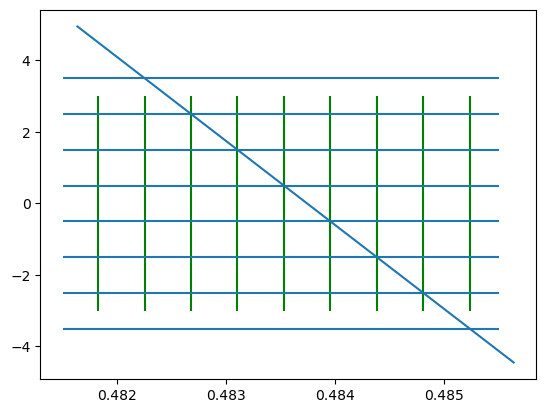

PyObject <matplotlib.collections.LineCollection object at 0x7f704ad98ad0>

In [196]:
plot(θrange, [zone_map(ωp - ωi, θs, 0, gvec, P, D, [0,0,0])[1] for θs in θrange])
vlines(θx, -3,3, "green")
hlines(-3.5:3.5, 0.4815,0.4855)

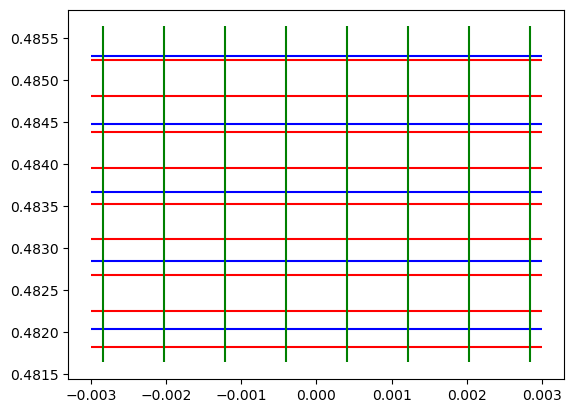

PyObject <matplotlib.collections.LineCollection object at 0x7f704b25ccd0>

In [184]:

a = 0.5e-6
θy = [c/(ωs*sin(θB))*(π/a + 2π*n/a) for n in -4:3] #for y
θz = [acos(-c/(ωs)*(π/a + 2*n*π/a) + ωp/ωs * cos(θB)) for n in -2:2]
θx = [asin(-*(1+2*n)*π*c/(ωs*a) - ωp/ωs * sin(θB) + g*c/ωs) for n in -4:4]

hlines(θx, minimum(ϕrange), maximum(ϕrange), "red")
hlines(θz, minimum(ϕrange), maximum(ϕrange), "blue")
vlines(θy, minimum(θrange), maximum(θrange), "green")


    

#next step is to take an angle and put it in a zone. 